In [257]:
import numpy as np
import pandas as pd
import requests as rq
import matplotlib.pyplot as plt

from prophet import Prophet
from xgboost import XGBRegressor
import matplotlib.dates as mdates
from bs4 import BeautifulSoup as bs
from datetime import timedelta, date
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### ATUALIZAÇÃO DE DADOS

In [258]:
headers = {
    'User-Agent': 'Mozilla/5.0',
    'X-Requested-With': 'XMLHttpRequest',
    'Content-Type': 'application/x-www-form-urlencoded'
}


url = 'https://br.investing.com/indices/bovespa-historical-data'
response = rq.get(url, headers=headers)

soup = bs(response.content)
tabela = soup.find('table')


actual_df = pd.read_html(str(tabela), parse_dates=['Data'], index_col='Data')[0].drop_duplicates()

today = date.today()
actual_df = actual_df.query('index < @today')
actual_df['Var%'] = actual_df['Var%'] .str.replace('+', '')

C:\Users\dhlui\AppData\Local\Temp\ipykernel_22096\3350626653.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  actual_df = pd.read_html(str(tabela), parse_dates=['Data'], index_col='Data')[0].drop_duplicates()
C:\Users\dhlui\AppData\Local\Temp\ipykernel_22096\3350626653.py:15: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  actual_df = pd.read_html(str(tabela), parse_dates=['Data'], index_col='Data')[0].drop_duplicates()


### TRATAMENTOS INICIAIS

In [259]:
historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')
historic_df = pd.concat([historic_df, actual_df])

historic_df = historic_df[~historic_df.index.duplicated(keep='last')]
historic_df = historic_df.sort_index()


historic_df.to_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv')

historic_df = historic_df.sort_index()

historic_df['Var%'] = historic_df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

historic_df['Vol.'] = historic_df['Vol.'].str.replace(',', '.')

historic_df['Vol.'] = historic_df['Vol.'].apply(
    lambda x: float(str(x)[:-1].replace(',', '.'))/1_000  if str(x)[-1] == 'K'
    else float(str(x)[:-1].replace(',', '.')) if str(x)[-1] == 'M'
    else float(str(x)[:-1].replace(',', '.')) * 1_000 if str(x)[-1] == 'B'
    else float(str(x).replace(',', '.'))/1_000_000 )

historic_df.rename(columns={'Vol.':'Vol (M)'}, inplace=True)

### CRIAÇÃO DE TREND LINE

In [260]:
delta_date = historic_df['Último'].iloc[-1] - historic_df['Último'].iloc[0]
line_trend = delta_date/(len(historic_df)-1)
historic_df['Trend'] = (line_trend * range(len(historic_df))) + historic_df['Último'].iloc[0]

### PLOT PARA AVALIAÇÃO INICIAL

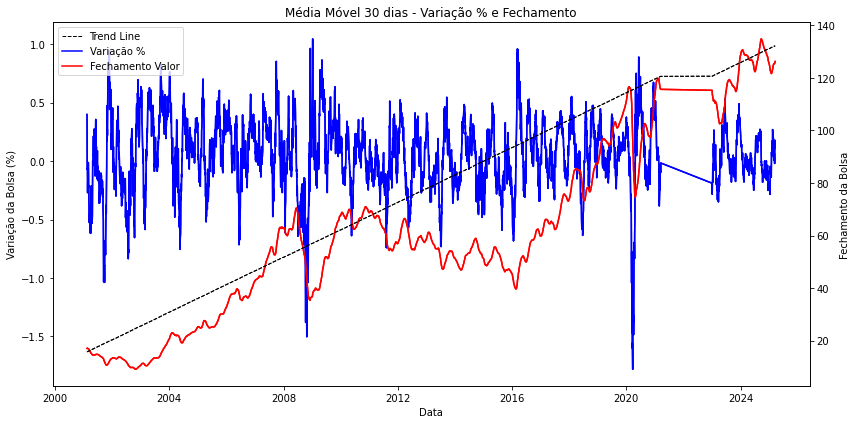

In [261]:
fig, ax = plt.subplots(figsize=(12,6))


line1, = ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.set_xlabel('Data')
ax.set_ylabel('Variação da Bolsa (%)')
ax.tick_params(axis='y')


ay = ax.twinx()
line2, = ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
line3, = ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(), 
                 color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(),
         color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.set_ylabel('Fechamento da Bolsa')
ay.tick_params(axis='y')


lines = [line3, line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

plt.title('Média Móvel 30 dias - Variação % e Fechamento')
fig.tight_layout()

# Exibir gráfico
plt.show()

### TESTE ADF SEM DIFF

In [262]:
historic_var_df = historic_df[['Último']]
X = historic_var_df[['Último']].values

result = adfuller(X)

print('Teste ADF')
print(f'Teste Estatístico: {result[0]}')
print(f'P-Value: {result[1]}')
print('Valores críticos:')

for key, value in result[4].items():
  print(f'\t{key}: {value}')


Teste ADF
Teste Estatístico: -0.5399630918331072
P-Value: 0.8839792440918235
Valores críticos:
	1%: -3.431532207416466
	5%: -2.8620624189367487
	10%: -2.5670480823255235


### CRIANDO BASE DE TREINO E TESTE

C:\Users\dhlui\AppData\Local\Temp\ipykernel_22096\3061036111.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)
C:\Users\dhlui\AppData\Local\Temp\ipykernel_22096\3061036111.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)
C:\Users\dhlui\AppData\Local\Temp\ipykernel_22096\3061036111.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

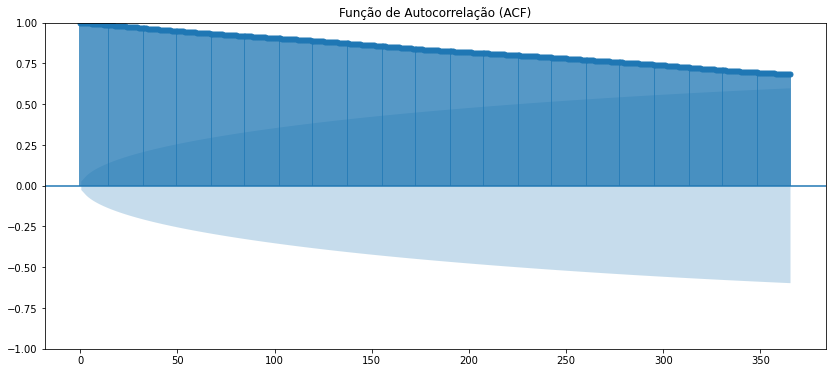

In [263]:
historic_df['day'] = historic_df.index.day
historic_df['week_of_year'] = [dt.weekofyear for dt in historic_df.index]
historic_df['month'] = historic_df.index.month
historic_df['year'] = historic_df.index.year


# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plot_acf(historic_df['Último'].dropna(), ax=plt.gca(), lags=365)
plt.title('Função de Autocorrelação (ACF)')


# Define training and test sets
n_lags = 365
for lag in range(1, n_lags + 1):
    historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)


# Rolling statistics
historic_df[f'rolling_mean_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).mean().shift(1)
historic_df[f'rolling_std_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).std().shift(1)

# Exponential Moving Averages (EMA)
historic_df[f'ema_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).mean().shift(1)
historic_df[f'ema_std_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).std().shift(1)


predictors = [
    'day',
    'week_of_year',
    'month',
    'year',
    *['lag_{}'.format(i) for i in range(1, n_lags + 1)],
    'rolling_mean_{n_lags}'.format(n_lags=n_lags),
    'rolling_std_{n_lags}'.format(n_lags=n_lags),
    'ema_{n_lags}'.format(n_lags=n_lags),
    'ema_std_{n_lags}'.format(n_lags=n_lags),
]


train_end = (date.today()-timedelta(7)).strftime('%Y-%m-%d')

df_train = historic_df.loc[:train_end]
df_test = historic_df.loc[train_end:]

### CRIANDO O NAIVE PREDICT

In [264]:
naive_pred = pd.Series(index=historic_df.index, dtype='float64')
naive_pred.loc[df_train.index] = historic_df['Último'].shift(1).loc[df_train.index]
last_train_value = historic_df['Último'].loc[df_train.index[-1]]
naive_pred.loc[df_test.index] = last_train_value


# Evaluation
from sklearn.metrics import mean_squared_error

mse_naive = mean_squared_error(df_test['Último'][1:], naive_pred.loc[df_test.index][1:])
print(f'Naive Baseline MSE: {mse_naive}')

Naive Baseline MSE: 29.831023500000008


### CRIANDO XGBoost PREDICT

In [265]:

# Define features and target
X_train = df_train[predictors]
y_train = df_train['Último']
X_test = df_test[predictors]
y_test = df_test['Último']

# TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=100)
xgb = XGBRegressor(objective='reg:squarederror')

# Train with cross-validation
xgb_models = []
mse = []
count = 0
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb.fit(X_tr, y_tr)
    val_pred = xgb.predict(X_val)
    # print(f'{count} Validation MSE: {mean_squared_error(y_val, val_pred)}')
    count = count + 1 
    mse.append(mean_squared_error(y_val, val_pred))
    xgb_models.append(xgb)

best_model_idx = mse.index(min(mse))
print(f'Best Model Idx: {best_model_idx}')

xgb = xgb_models[best_model_idx]

# Predict on the test set
xgb_pred = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost MSE: {mse_xgb}')

xgb_pred_series = pd.Series(xgb_pred, index=df_test.index, name='pred')
xgb_pred_df = xgb_pred_series.astype('float64')

Best Model Idx: 7
XGBoost MSE: 17.814369407683266


### CRIANDO ARIMA PREDICT

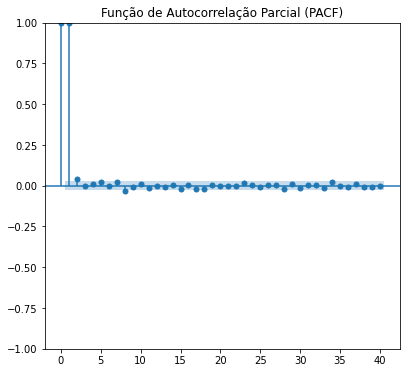

c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

ARIMA MSE: 26.587150925485208


c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [266]:
# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plt.subplot(122)
plot_pacf(historic_df['Último'].dropna(), ax=plt.gca(), lags=40)
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.show()

p = 3 
d = 1
q = 40

model_arima = ARIMA(df_train['Último'], order=(p, d, q))
resultado_arima = model_arima.fit()

arima_pred = resultado_arima.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1)

arima_mse = mean_squared_error(y_test, arima_pred)
print(f'ARIMA MSE: {arima_mse}')

arima_pred.index = df_test.index 
arima_pred_series = pd.Series(arima_pred, index=df_test.index, name='pred')
arima_pred_df = arima_pred_series.astype('float64')

### CRIANDO O PROPHET PREDICT

15:10:43 - cmdstanpy - INFO - Chain [1] start processing
15:10:47 - cmdstanpy - INFO - Chain [1] done processing


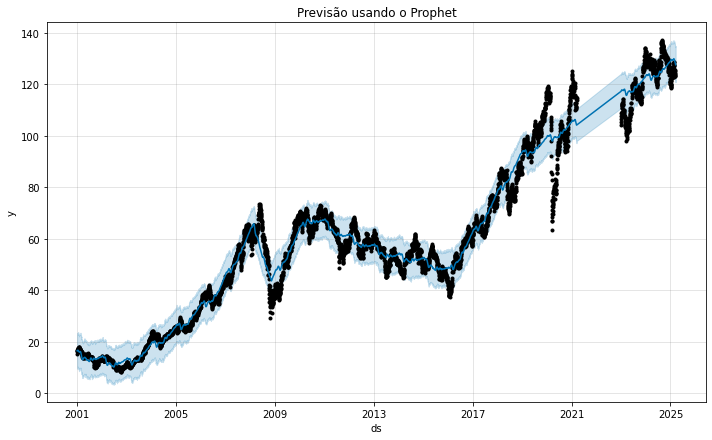

In [267]:
data = df_train[['Último']].copy()
data['ds'] = data.index

data.rename(columns={'Último': 'y'}, inplace=True)

delta_days = (df_test.index[-1]-df_train.index[-1]).days


# Ajustando o modelo Prophet com o seu DataFrame
model = Prophet()
model.fit(data)

# Gerando o futuro para o número de dias calculado
future = model.make_future_dataframe(periods=delta_days)

# Fazendo a previsão
prophet_pred = model.predict(future)


fig = model.plot(prophet_pred)

# Exibindo o gráfico
plt.title('Previsão usando o Prophet')
plt.show()

prophet_pred.set_index('ds', inplace=True)
prophet_pred_series = pd.Series(prophet_pred['yhat'], index=df_test.index, name='pred')
prophet_pred_df = prophet_pred_series.astype('float64')


### CRIANDO O RANDOM FOREST PREDICT

In [268]:
from sklearn.ensemble import RandomForestRegressor

# Remover nulos após defasagens
df_train_rf = df_train.dropna()
X_train_rf = df_train_rf[predictors]
y_train_rf = df_train_rf['Último']

df_test_rf = df_test.dropna()
X_test_rf = df_test_rf[predictors]
y_test_rf = df_test_rf['Último'].loc[X_test_rf.index]

# Modelo
rf_model = RandomForestRegressor(n_estimators=100)


rf_model.fit(X_train_rf, y_train_rf)
rf_pred = rf_model.predict(X_test_rf)


rf_pred_series = pd.Series(rf_pred, index=df_test.index, name='pred')
rf_pred_df = rf_pred_series.astype('float64')

### TESTE DE CONFIABILIDADE

In [269]:

mae_naive = mean_absolute_error(df_test['Último'], naive_pred[train_end:])
rmse_naive = mean_squared_error(df_test['Último'], naive_pred[train_end:])
mape_naive = 100 * mean_absolute_percentage_error(df_test['Último'], naive_pred[train_end:])

mae_xgb = mean_absolute_error(df_test['Último'], xgb_pred)
rmse_xgb = mean_squared_error(df_test['Último'], xgb_pred)
mape_xgb = 100 * mean_absolute_percentage_error(df_test['Último'], xgb_pred)

mae_arima = mean_absolute_error(df_test['Último'], arima_pred)
rmse_arima = mean_squared_error(df_test['Último'], arima_pred)
mape_arima = 100 * mean_absolute_percentage_error(df_test['Último'], arima_pred)

mae_prophet = mean_absolute_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])
rmse_prophet = mean_squared_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])
mape_prophet = 100 * mean_absolute_percentage_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])

mae_rf = mean_absolute_error(df_test['Último'], rf_pred)
rmse_rf = mean_squared_error(df_test['Último'], rf_pred)
mape_rf = 100 * mean_absolute_percentage_error(df_test['Último'], rf_pred)


resultados = pd.DataFrame(
    {
        'Modelo': ['XGBoost', 'Naive', 'Arima', 'Prophet', 'Random Forest'],
        'MAE': [mae_xgb, mae_naive, mae_arima, mae_prophet, mae_rf],
        'RMSE': [rmse_xgb, rmse_naive, rmse_arima, rmse_prophet, rmse_rf],
        'MAPE (%)': [mape_xgb, mape_naive, mape_arima, mape_prophet, mape_rf],
        'Accuracy (%)': [
            100 - mape for mape in [mape_xgb, mape_naive, mape_arima, mape_prophet, mape_rf]
        ],
    }
).sort_values('MAPE (%)').reset_index(drop=True)

resultados


,Modelo,MAE,RMSE,MAPE (%),Accuracy (%)
0,Random Forest,1.362778,3.063161,1.050858,98.949142
1,Prophet,3.073107,11.171134,2.353877,97.646123
2,XGBoost,4.139268,17.814369,3.177829,96.822171
3,Naive,4.245200,23.864819,3.234489,96.765511
4,Arima,4.501018,26.587151,3.430094,96.569906


### VISUALIZAÇÃO DE TODOS OS TESTE

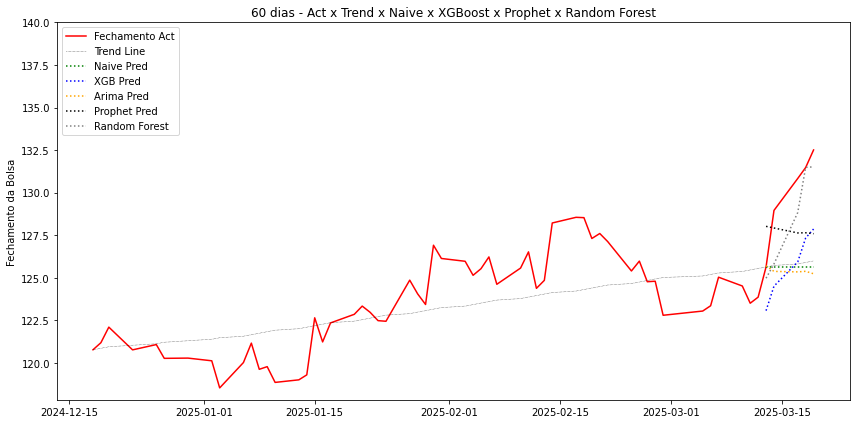

In [270]:
historic_filter = historic_df.copy().tail(60)
delta_date = historic_filter[:train_end]['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter[:train_end])-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]


naive_filter = naive_pred.tail(20)


fig, ax = plt.subplots(figsize=(12,6))

# Fechamento act
line2, = ax.plot(historic_filter.index, historic_filter['Último'], color='red', label='Fechamento Act')

# Linha de tendência
line3, = ax.plot(historic_filter.index, historic_filter['Trend'], 
                 color='black', label='Trend Line', linestyle=':', linewidth=0.5)

# Previsão Naive 
line4, = ax.plot(df_test.index, naive_filter.loc[df_test.index], color='green', linestyle=':', linewidth=1.5, label='Naive Pred')

# Previsão XGBoost
line5, = ax.plot(df_test.index, xgb_pred_df.loc[df_test.index], color='blue', linestyle=':', linewidth=1.5, label='XGB Pred')

# Previsão Arima
line6, = ax.plot(df_test.index, arima_pred_df.loc[df_test.index], color='orange', linestyle=':', linewidth=1.5, label='Arima Pred')

# Previsão Prophet
line7, = ax.plot(df_test.index, prophet_pred_df.loc[df_test.index], color='black', linestyle=':', linewidth=1.5, label='Prophet Pred')

# Previsão Prophet
line8, = ax.plot(df_test.index, rf_pred_df.loc[df_test.index], color='gray', linestyle=':', linewidth=1.5, label='Random Forest')

ax.set_ylabel('Fechamento da Bolsa')
ax.tick_params(axis='y')

# Título e legenda
lines = [line2, line3, line4, line5, line6, line7, line8]  # A lista de objetos de linha
# Usando get_label() corretamente
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')
ax.set_ylim(top=140)


plt.title('60 dias - Act x Trend x Naive x XGBoost x Prophet x Random Forest')
fig.tight_layout()

plt.show()

### CRIAÇÃO DE INTERVALO DE SEGURANÇA COM RANDOM FOREST

In [271]:
predictions = np.array([tree.predict(X_test_rf) for tree in rf_model.estimators_])

# Média das previsões (previsão final)
rf_pred = predictions.mean(axis=0)
std_dev = predictions.std(axis=0)
lower_bound = rf_pred - 1.96 * std_dev  # Intervalo inferior
upper_bound = rf_pred + 1.96 * std_dev  # Intervalo superior

rf_intervalo = pd.DataFrame({
    'pred': rf_pred,
    'lower': lower_bound,
    'upper': upper_bound
}, index=df_test.index)

c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature nam

### VISUALIZAÇÃO DE PREDIÇÃO COM INTERVALO DE SEGURANÇA RF

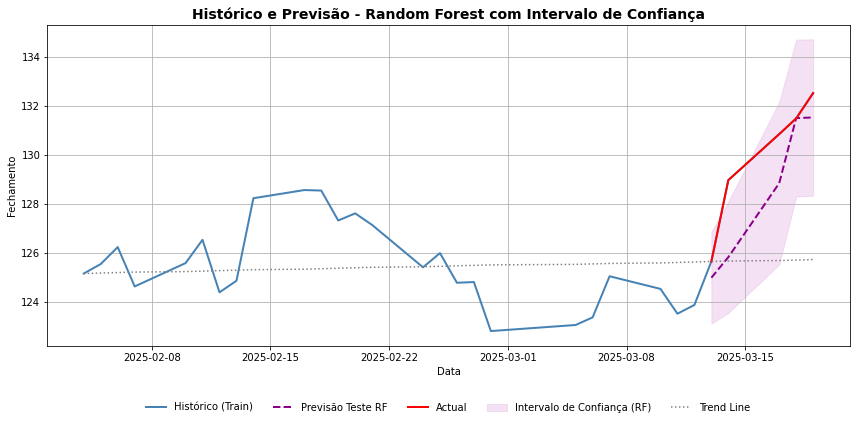

In [272]:
historic_filter = historic_df.copy().tail(30)
delta_date = historic_filter[:train_end]['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter[:train_end])-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]

fig, ax = plt.subplots(figsize=(12,6))

# Plot histórico
ax.plot(historic_filter.index, historic_filter['Último'], label='Histórico (Train)', color='steelblue', linewidth=2)

# Plot Previsão Random Forest
ax.plot(rf_intervalo.index, rf_intervalo['pred'], label='Previsão Teste RF', color='darkmagenta', linestyle='--', linewidth=2)
ax.plot(df_test.index, df_test['Último'], label='Actual', color='red', linestyle='-', linewidth=2)

# Plot faixa de intervalo de confiança (shaded area)
ax.fill_between(rf_intervalo.index, 
                rf_intervalo['lower'], 
                rf_intervalo['upper'], 
                color='plum', alpha=0.3, label='Intervalo de Confiança (RF)')

# Linha de referência (último valor do histórico)
ax.plot(historic_filter.index, historic_filter['Trend'], color='gray', linestyle=':', linewidth=1.5, label='Trend Line')


# Eixos
ax.set_title('Histórico e Previsão - Random Forest com Intervalo de Confiança', fontsize=14, fontweight='bold')
ax.set_ylabel('Fechamento')
ax.set_xlabel('Data')

# Estética
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)
ax.grid(True)
plt.tight_layout()
plt.show()


### PREDIÇÃO DOS PRÓXIMOS 3 DIAS

In [273]:
historic_pred_df = historic_df.copy()

historic_pred_df.drop(columns=['Abertura','Máxima','Mínima','Vol (M)','Var%', 'Trend'], axis=1, inplace=True)

index_pred = [today + timedelta(days=i) for i in range(3)]
index_pred = [pd.to_datetime(date) for date in index_pred]

df_pred = pd.DataFrame(columns=[predictors], index=index_pred)


df_pred['day'] = df_pred.index.day
df_pred['week_of_year'] = df_pred.index.isocalendar().week 
df_pred['month'] = df_pred.index.month 
df_pred['year'] = df_pred.index.year

predictions_final = []

for step in range(3):
    data_pred = pd.to_datetime(today + timedelta(days=step))

    for lag in range(1, 41):
        df_pred.loc[data_pred, f'lag_{lag}'] = historic_pred_df['Último'].iloc[-lag]


    df_pred.loc[data_pred, f'rolling_mean_{n_lags}'] = historic_pred_df['Último'].rolling(window=n_lags).mean().iloc[-1]
    df_pred.loc[data_pred, f'rolling_std_{n_lags}'] = historic_pred_df['Último'].rolling(window=n_lags).std().iloc[-1]


    df_pred.loc[data_pred, f'ema_{n_lags}'] = historic_pred_df['Último'].ewm(span=n_lags).mean().iloc[-1]
    df_pred.loc[data_pred, f'ema_std_{n_lags}'] = historic_pred_df['Último'].ewm(span=n_lags).std().iloc[-1]


    df_pred.columns = [str(col[0]) if isinstance(col, tuple) else str(col) for col in df_pred.columns]


    rf_pred = rf_model.predict(df_pred.loc[[data_pred]])
    

    prediction = np.array([tree.predict(df_pred.loc[[data_pred]])[0] for tree in rf_model.estimators_])
    predictions_final.append(prediction)


    new_row = df_pred.loc[[data_pred]].copy()
    new_row['Último'] = float(rf_pred)
    historic_pred_df = pd.concat([historic_pred_df, new_row])

predictions_final = np.array(predictions_final)

rf_pred_final = predictions_final.mean(axis=1)
std_dev_final = predictions_final.std(axis=1)
lower_bound_final = rf_pred_final - 1.96 * std_dev_final
upper_bound_final = rf_pred_final + 1.96 * std_dev_final


dates_pred = [pd.to_datetime(today + timedelta(days=i)) for i in range(3)]

rf_intervalo_final = pd.DataFrame({
    'pred': rf_pred_final,
    'lower': lower_bound_final,
    'upper': upper_bound_final
}, index=dates_pred)


historic_pred_df['Var%'] = round((historic_pred_df['Último'] /historic_pred_df['Último'].shift(1)-1)*100,2) 


rf_intervalo_final = rf_intervalo_final.merge(historic_pred_df[['Var%']], 
                                              how='left', 
                                              left_index=True, 
                                              right_index=True)


c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\dhlui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature nam

### VISUALIZAÇÃO DE PREDIÇÃO

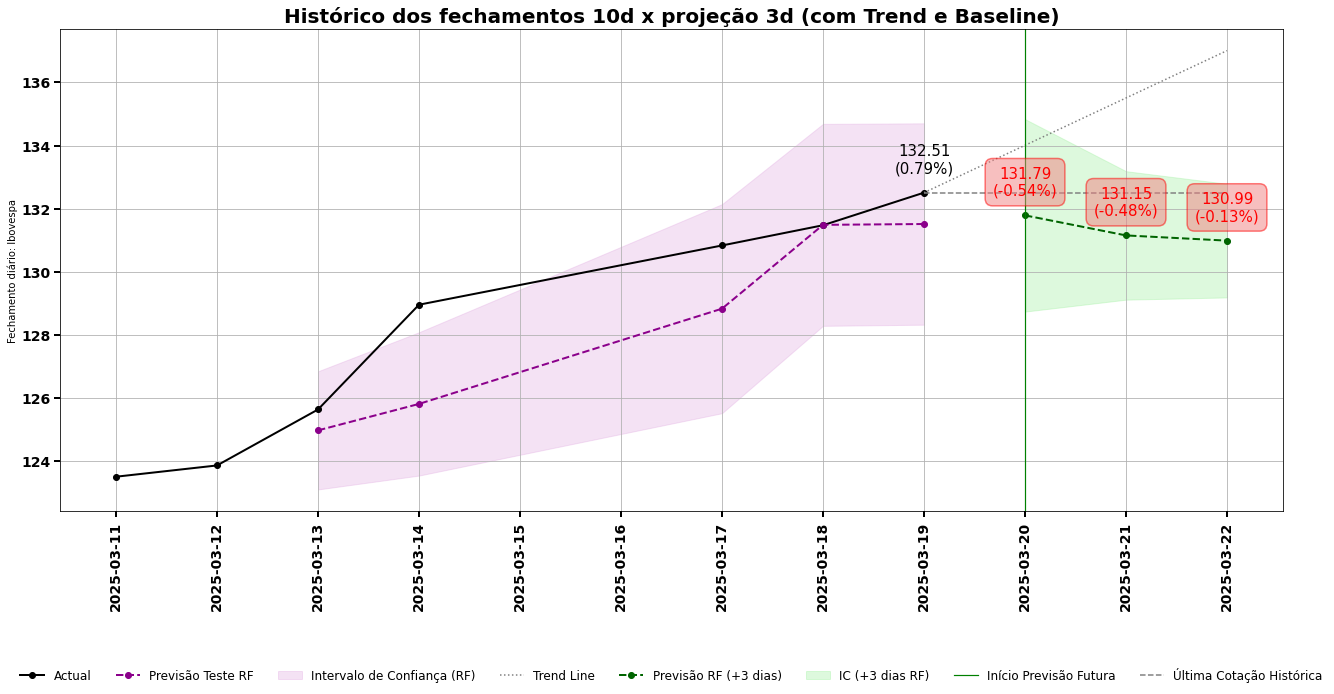

In [274]:
historic_filter = historic_pred_df.copy().tail(10)
delta_date = historic_filter[:pd.to_datetime(today-timedelta(1))]['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter[:pd.to_datetime(today-timedelta(1))])-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(20, 10))

# Plot histórico
ax.plot(historic_filter[:pd.to_datetime(today - timedelta(1))].index, 
        historic_filter[:pd.to_datetime(today - timedelta(1))]['Último'], 
        label='Actual', color='black', linewidth=2, marker='o')

# Adicionar rótulo de dados no último dia do Actual
ultimo_dia_actual = historic_filter[:pd.to_datetime(today - timedelta(1))].index[-1]
ultimo_valor_actual = historic_filter[:pd.to_datetime(today - timedelta(1))]['Último'].iloc[-1]
ultimo_var_percentual = historic_filter[:pd.to_datetime(today - timedelta(1))]['Var%'].iloc[-1]

# Texto da anotação com o valor do 'Último' e 'Var%'
texto_anotacao = f'{ultimo_valor_actual:.2f}\n({ultimo_var_percentual:.2f}%)'

# Adicionar anotação ao gráfico
ax.annotate(texto_anotacao, 
            xy=(ultimo_dia_actual, ultimo_valor_actual), 
            xytext=(0, 20),  # Deslocar o texto 20 pontos acima do ponto
            textcoords='offset points', 
            fontsize=15, color='black', ha='center')  # Centralizar horizontalmente

# Plot Previsão Random Forest
ax.plot(rf_intervalo.index, rf_intervalo['pred'], 
        label='Previsão Teste RF', color='darkmagenta', linestyle='--', linewidth=2, marker='o')

# Plot faixa de intervalo de confiança (shaded area)
ax.fill_between(rf_intervalo.index, 
                rf_intervalo['lower'], 
                rf_intervalo['upper'], 
                color='plum', alpha=0.3, label='Intervalo de Confiança (RF)')

# Linha de referência (Trend Line) - apenas a partir de today
ax.plot(historic_filter[pd.to_datetime(today-timedelta(1)):].index, 
        historic_filter[pd.to_datetime(today-timedelta(1)):]['Trend'], 
        color='gray', linestyle=':', linewidth=1.5, label='Trend Line')

# Plot Previsão Futura RF (+3 dias)
ax.plot(rf_intervalo_final.index, rf_intervalo_final['pred'], 
        label='Previsão RF (+3 dias)', color='darkgreen', linestyle='--', linewidth=2, marker='o')


# Adicionar rótulos de dados na Previsão Futura RF
for i, (data, valor) in enumerate(zip(rf_intervalo_final.index, rf_intervalo_final['pred'])):
    var_percentual = rf_intervalo_final['Var%'].iloc[i]  # Valor da coluna Var%
    texto_anotacao = f'{valor:.2f}\n({var_percentual:.2f}%)'  # Texto formatado
    
    # Definir a cor do texto e do fundo com base no valor de Var%
    if var_percentual > 0:
        cor_texto = 'darkgreen' 
        cor_fundo = 'lightgreen'  
    else:
        cor_texto = 'red' 
        cor_fundo = 'lightcoral'  
    
    # Adicionar anotação ao gráfico com caixa de fundo e 50% de transparência
    ax.annotate(texto_anotacao, 
                xy=(data, valor), 
                xytext=(0, 20),  # Deslocar o texto 20 pontos acima do ponto
                textcoords='offset points', 
                fontsize=15, color=cor_texto, ha='center',  # Cor e alinhamento do texto
                bbox=dict(boxstyle='round,pad=0.5',  # Estilo da caixa (arredondada)
                        facecolor=cor_fundo,  # Cor de fundo da caixa
                        edgecolor=cor_texto,  # Cor da borda (igual ao texto)
                        linewidth=1.5,  # Espessura da borda
                        alpha=0.5))  # 50% de transparência


# Intervalo de confiança da previsão futura
ax.fill_between(rf_intervalo_final.index, 
                rf_intervalo_final['lower'], 
                rf_intervalo_final['upper'], 
                color='lightgreen', alpha=0.3, label='IC (+3 dias RF)')

# Linha vertical separando histórico/teste da previsão futura
ax.axvline(x=rf_intervalo_final.index[0], color='green', linestyle='-', 
           linewidth=1.2, label='Início Previsão Futura')

# Linha horizontal da última cotação histórica (apenas a partir de today)
ultima_cotacao = historic_filter['Último'][:pd.to_datetime(today - timedelta(1))].iloc[-1]
ax.hlines(y=ultima_cotacao, xmin=pd.to_datetime(today-timedelta(1)), xmax=historic_filter.index[-1], 
          color='gray', linestyle='--', linewidth=1.5, label='Última Cotação Histórica')


# Formatar eixo x para mostrar dia a dia
ax.xaxis.set_major_locator(mdates.DayLocator())  # Mostrar cada dia
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato da data
plt.xticks(rotation=90)  # Rotacionar as labels do eixo x para melhor visualização

ax.tick_params(axis='x', labelsize=14, width=2, length=6, color='black')  # Aumentar tamanho e espessura
for label in ax.get_xticklabels():
    label.set_fontweight('bold')  # Deixar em negrito


ax.tick_params(axis='y', labelsize=14, width=2, length=6, color='black')  # Aumentar tamanho e espessura
for label in ax.get_yticklabels():
    label.set_fontweight('bold')  # Deixar em negrito


# Eixos
ax.set_title('Histórico dos fechamentos 10d x projeção 3d (com Trend e Baseline)', 
             fontsize=20, fontweight='bold')

ax.set_ylabel('Fechamento diário: Ibovespa')

# Estética
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=8, frameon=False, fontsize=12)
ax.grid(True)
plt.tight_layout()

# Salvar o gráfico como PNG
plt.savefig('grafico_previsao.jpeg', dpi=300, bbox_inches='tight')
plt.show()
